# Train on separate images (CNN-Only) on InceptionV3 output

In [1]:
import numpy as np
import os
from os.path import join
from keras import layers
from keras.models import Model
from utils import preprocess_images_tf, take
from tqdm import tqdm

from image_generators import train_generator_single_images, valid_generator_single_images

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#from keras_utils import set_keras_session
#set_keras_session()

In [3]:
dataset = 'UCF11'
nb_classes = int(dataset[3:])

In [ ]:
def count_num_videos(dataset_dir, *split_keys):
    for split_key in split_kyes:
        yield sum(len(os.listdir(join(dataset_dir, split_key, cl))) for cl in os.listdir(join(dataset_dir, split_key)))

In [4]:
frame_number = 50
width = 320
height = 240

dataset_dir = join('datasets', dataset, ('separate_frames_{}_h_{}_w_{}').format(frame_number, height, width))

train_samples_count, valid_samples_count = count_num_videos(dataset_dir, 'train', 'valid')

In [5]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = layers.Dense(nb_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [6]:
from keras import metrics
from functools import partial

top_3_k_categorical_accuracy = partial(metrics.top_k_categorical_accuracy, k=3)
top_3_k_categorical_accuracy.__name__ = 'top_3'

model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

In [7]:
batch_size = 128
train_generator = train_generator_single_images(dataset_dir, batch_size)
valid_generator = valid_generator_single_images(dataset_dir)

history = model.fit_generator(train_generator,
                    steps_per_epoch=train_samples_count * frame_number // batch_size, 
                    validation_data=valid_generator,
                    validation_steps=valid_samples_count,
                    epochs=1)

Epoch 1/1
439/439 [==============================] - 310s 706ms/step - loss: 0.6275 - acc: 0.8050 - top_3: 0.9381 - val_loss: 1.3130 - val_acc: 0.6645 - val_top_3: 0.8807


Here we collect metrics about the accuracy on the video, since the model only works with single images:
* Approach 1: Compute the mean of all predictions on all frames of a video, then take the best prediction.
* Approach 2: Take the predicted best for each frame (argmax), and count how many times that class is predicted as the best one into the video frames. Then take the class with the highest count.
* Approach 3 (not implemented but tested): instead of the mean, compute the product (since we work with probabilities). Yields a lower result than using the mean.

In [10]:
from collections import Counter

count_videos = 0
count_top_1 = 0
count_top_3 = 0
count_top_1_argmax = 0

for frames, labels in tqdm(take(valid_generator, valid_samples_count), total=valid_samples_count):
    
    ### Compute the predicted labels using the model
    
    true_labels = labels[0]
    true_label_idx = np.argmax(true_labels)
    predicted_labels = model.predict(frames)
    
    ### Update counters with Approach 1 (mean)
    
    predicted_labels_mean = np.mean(predicted_labels, axis=0)
    predicted_labels_mean_idx = np.argmax(predicted_labels_mean)
    idx_sorted_top_3 = np.argsort(predicted_labels_mean)[-3:]
    
    if true_label_idx in idx_sorted_top_3:
        count_top_3 += 1
        
    if true_label_idx == predicted_labels_mean_idx:
        count_top_1 += 1
        
    ### Update count with Approach 2 (highest count)
    
    predicted_labels_argmax = np.argmax(predicted_labels, axis=1)
    counter = Counter(predicted_labels_argmax)
    
    if counter.most_common(1)[0][0] == true_label_idx:
        count_top_1_argmax += 1
        
    ### Update number of videos
        
    count_videos += 1

100%|██████████| 469/469 [03:18<00:00,  2.37it/s]


In [11]:
print('Top 1 accuracy (using mean):', count_top_1 / count_videos)
print('Top 3 accuracy (using mean):', count_top_3 / count_videos)
print('Top 1 accuracy (using highest count):', count_top_1_argmax / count_videos)

Top 1 accuracy (using mean): 0.7292110874200426
Top 3 accuracy (using mean): 0.9125799573560768
Top 1 accuracy (using highest count): 0.7228144989339019


In [13]:
model.save('models/UCF11/inception_dense256_dropout05_trained_1_epoch_no_fine_tuning.h5')

In [24]:
from keras.optimizers import SGD

"""After we fine-tune the dense layers, train deeper."""
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
    layer.trainable = False
for layer in model.layers[172:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy', top_3_k_categorical_accuracy])

In [17]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=train_samples_count * frame_number // batch_size, 
                    validation_data=valid_generator,
                    validation_steps=valid_samples_count,
                    epochs=20)

Epoch 1/20
439/439 [==============================] - 379s 863ms/step - loss: 0.2201 - acc: 0.9376 - top_3: 0.9905 - val_loss: 0.8348 - val_acc: 0.7324 - val_top_3: 0.9162
Epoch 2/20
439/439 [==============================] - 375s 854ms/step - loss: 0.1241 - acc: 0.9682 - top_3: 0.9967 - val_loss: 0.7965 - val_acc: 0.7455 - val_top_3: 0.9222
Epoch 3/20
439/439 [==============================] - 374s 853ms/step - loss: 0.0898 - acc: 0.9779 - top_3: 0.9978 - val_loss: 0.7836 - val_acc: 0.7521 - val_top_3: 0.9240
Epoch 4/20
439/439 [==============================] - 374s 851ms/step - loss: 0.0673 - acc: 0.9847 - top_3: 0.9983 - val_loss: 0.7686 - val_acc: 0.7574 - val_top_3: 0.9282
Epoch 5/20
439/439 [==============================] - 374s 852ms/step - loss: 0.0544 - acc: 0.9882 - top_3: 0.9990 - val_loss: 0.7542 - val_acc: 0.7635 - val_top_3: 0.9302
Epoch 6/20
439/439 [==============================] - 374s 851ms/step - loss: 0.0463 - acc: 0.9899 - top_3: 0.9991 - val_loss: 0.7512 - val_

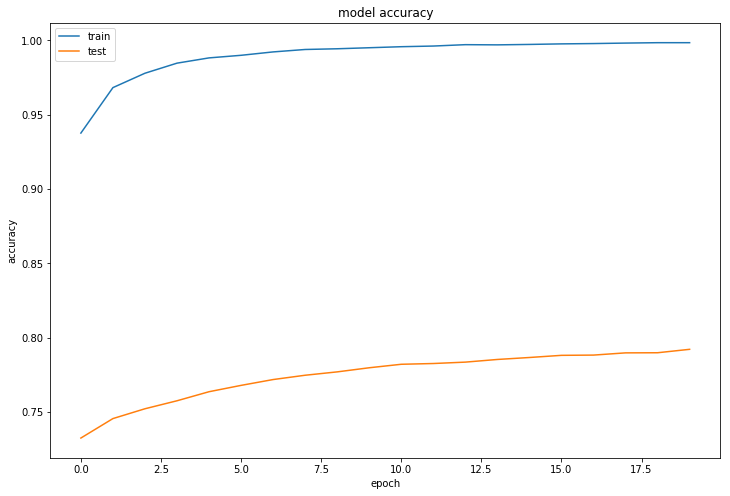

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
from keras.models import load_model

model = load_model('models/UCF11/inception_dense256_dropout05_trained_1_epoch_sgd_fine_tuning_20_epochs.h5', 
                   custom_objects={'top_3': top_3_k_categorical_accuracy})

In [30]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=train_samples_count * frame_number // batch_size, 
                    validation_data=valid_generator,
                    validation_steps=valid_samples_count,
                    epochs=1)

Epoch 1/1
439/439 [==============================] - 373s 850ms/step - loss: 0.0114 - acc: 0.9982 - top_3: 0.9999 - val_loss: 0.7196 - val_acc: 0.7922 - val_top_3: 0.9400


In [31]:
from collections import Counter

count_videos = 0
count_top_1 = 0
count_top_3 = 0
count_top_1_argmax = 0

for frames, labels in tqdm(take(valid_generator, valid_samples_count), total=valid_samples_count):
    
    ### Compute the predicted labels using the model
    
    true_labels = labels[0]
    true_label_idx = np.argmax(true_labels)
    predicted_labels = model.predict(frames)
    
    ### Update counters with Approach 1 (mean)
    
    predicted_labels_mean = np.mean(predicted_labels, axis=0)
    predicted_labels_mean_idx = np.argmax(predicted_labels_mean)
    idx_sorted_top_3 = np.argsort(predicted_labels_mean)[-3:]
    
    if true_label_idx in idx_sorted_top_3:
        count_top_3 += 1
        
    if true_label_idx == predicted_labels_mean_idx:
        count_top_1 += 1
        
    ### Update count with Approach 2 (highest count)
    
    predicted_labels_argmax = np.argmax(predicted_labels, axis=1)
    counter = Counter(predicted_labels_argmax)
    
    if counter.most_common(1)[0][0] == true_label_idx:
        count_top_1_argmax += 1
        
    ### Update number of videos
        
    count_videos += 1

100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


In [32]:
print('Top 1 accuracy (using mean):', count_top_1 / count_videos)
print('Top 3 accuracy (using mean):', count_top_3 / count_videos)
print('Top 1 accuracy (using highest count):', count_top_1_argmax / count_videos)

Top 1 accuracy (using mean): 0.8443496801705757
Top 3 accuracy (using mean): 0.9722814498933902
Top 1 accuracy (using highest count): 0.835820895522388
